In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import scipy as sp

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import sys
import os
sys.path.append('../')
# sys.path.append('../power_law_rf')
import optimizers
from power_law_rf.power_law_rf import PowerLawRF
from power_law_rf.ode import ode_resolvent_log_implicit
from power_law_rf.ode import DanaHparams
from power_law_rf.ode import ODEInputs
from power_law_rf.least_squares import lsq_streaming_optax_simple
import power_law_rf.deterministic_equivalent as theory

key = random.PRNGKey(0)

In [2]:
ALPHA = 0.3
BETA = 0.7
V = 2000
D = 500
SGDBATCH=1
STEPS = 10**6

In [3]:
key, subkey = random.split(key)
problem = PowerLawRF.initialize_random(alpha=ALPHA, beta=BETA, v=V, d=D, key=subkey)


In [4]:
# Check if JAX is using CUDA/GPU
print("JAX devices:", jax.devices())
print("JAX default backend:", jax.default_backend())


JAX devices: [CpuDevice(id=0)]
JAX default backend: cpu


In [5]:
g1 = optimizers.powerlaw_schedule(1.0, 0.0, 0.0, 1)
g2 = optimizers.powerlaw_schedule(0.5/problem.population_trace, 0.0, 0.0, 1)
g3 = optimizers.powerlaw_schedule(1.0/problem.population_trace, 0.0, -1.0/(2*problem.alpha), 1)
Delta = optimizers.powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(problem.alpha+problem.beta)/(2*problem.alpha))
danadecayopt = optimizers.dana_optimizer(g1=g1,g2=g2,g3=g3,Delta=Delta)

In [6]:

#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
danadecaytimes,danadecaylosses = lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         danadecayopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:16<00:00,  1.70it/s]


In [7]:
# g1 = optimizers.powerlaw_schedule(1.0, 0.0, 0.0, 1)
# g2 = optimizers.powerlaw_schedule(0.5/problem.population_trace, 0.0, 0.0, 1)
# g3 = optimizers.powerlaw_schedule(0.1/problem.population_trace, 0.0, 0.0, 1)
# Delta = optimizers.powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(problem.alpha+problem.beta)/(2*problem.alpha))
# danafixedopt = optimizers.dana_optimizer_layerwise(g1=g1,g2=g2,g3=g3,Delta=Delta)

# #pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
# key, newkey = random.split(key)
# danafixedtimes,danafixedlosses = lsq_streaming_optax_simple(newkey, 
#                          problem.get_data, 
#                          SGDBATCH, 
#                          STEPS, 
#                          danafixedopt, 
#                          jnp.zeros((problem.d,1)), 
#                          problem.get_population_risk)

In [8]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
rho_init = problem.get_rhos()
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

Keigs = problem.get_hessian_spectra()
riskInftyTheory=problem.get_theory_limit_loss()

Dt = 10**(-3)

odeTimes_dana_decay2, odeRisks_dana_decay2 = ode_resolvent_log_implicit(
    ODEInputs(Keigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory),
    DanaHparams(g1, g2, g3, Delta),
    SGDBATCH, problem.d, STEPS, Dt)


In [ ]:
#Theory spectra generated by Newton (Elliot)

#Compute the theoretical limiting loss value
riskInftyTheory = tt_dbetacirc_VD(alpha, beta,V,D)
print('Theoretical limiting loss value is {}'.format(riskInftyTheory))

# Compute theoretical integrals using density approximation
lower_bound = tt_lmin(alpha)*(D**(-2*alpha)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha)) #tt_lmin(alpha)*(D**(-2*alpha)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha))
upper_bound = 1.0*1.1


#xs = jnp.linspace(lower_bound, upper_bound, 10000)

#err = -10
#batches = 1
#zs = xs.astype(jnp.complex64)

#density = jax_gen_trace_fmeasure(V, D, alpha, beta, zs, err=err, batches = batches)

fake_eigs = np.power(np.arange(1,D+1,dtype=jnp.float32),-2.0*alpha)
b_values = fake_eigs - 0.5 * jnp.diff(fake_eigs, prepend = upper_bound)
a_values = fake_eigs + 0.5 * jnp.diff(fake_eigs, append = lower_bound)
#rho_weights = deterministic_rho_weights(xs, density, a_values, b_values)


num_splits = 5
rho_weights = deterministic_rho_weights(num_splits, a_values, b_values)

print('Initial loss value is is {}'.format(jnp.sum( rho_weights*fake_eigs) + riskInftyTheory))

# Compute integrals
#dx = xs[1] - xs[0]

rho_init = rho_weights #density * dx
#num_grid_points = jnp.shape(xs)[0] #Represents the number of eigenvalues
num_grid_points = D
sigma_init = jnp.zeros(num_grid_points, dtype=jnp.float32)
chi_init = jnp.zeros(num_grid_points, dtype=jnp.float32)

Dt = 10**(-2) #10**(-2)


odeTimes_dana_decay_theory, odeRisks_dana_decay_theory = ode_resolvent_log_implicit_full(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory,
                                               g1_dana_decay, g2_dana_decay, g3_dana_decay, delta_dana_decay, sgd_batch, num_grid_points, sgd_steps, Dt)


In [23]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)

D=problem.d

lower_bound = theory.theory_lambda_min(problem.alpha)*(D**(-2*problem.alpha)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha)) #tt_lmin(alpha)*(D**(-2*alpha)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha))
upper_bound = 1.0*1.1
fake_eigs = jnp.power(jnp.arange(1,D+1,dtype=jnp.float32),-2.0*problem.alpha)
b_values = fake_eigs - 0.5 * jnp.diff(fake_eigs, prepend = upper_bound)
a_values = fake_eigs + 0.5 * jnp.diff(fake_eigs, append = lower_bound)

num_splits = 5
rho_weights = problem.get_deterministic_rho_weights(num_splits, a_values, b_values)

print('Initial loss value is is {}'.format(jnp.sum( rho_weights*fake_eigs) + riskInftyTheory))
rho_init = rho_weights
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)
riskInftyTheory=problem.get_theory_limit_loss()


TypeError: float() argument must be a string or a real number, not 'complex'

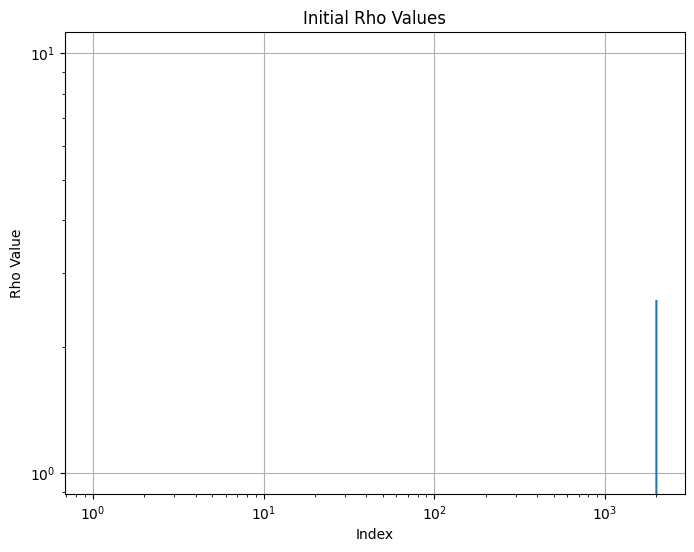

In [17]:
plt.figure(figsize=(8,6))
plt.plot(rho_init)
plt.xlabel('Index')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Rho Value')
plt.title('Initial Rho Values')
plt.grid(True)
plt.show()

In [ ]:

Dt = 10**(-3)

odeTimes_dana_decay3, odeRisks_dana_decay3 = ode_resolvent_log_implicit(
    ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
    DanaHparams(g1, g2, g3, Delta),
    SGDBATCH, problem.d, STEPS, Dt)

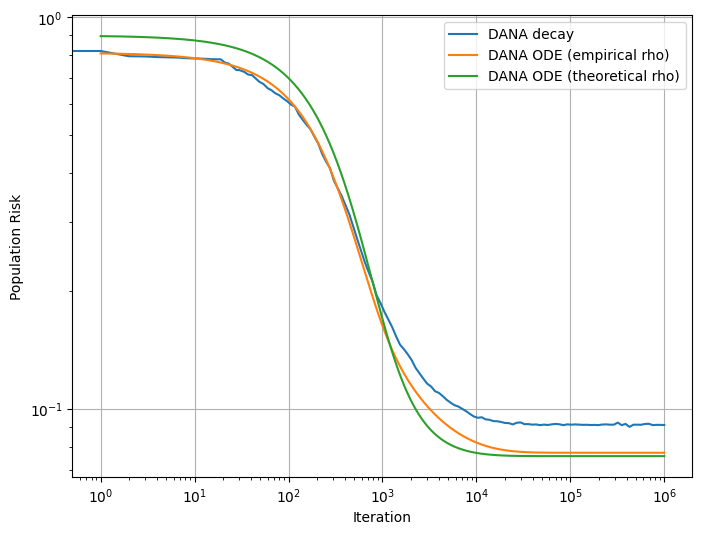

In [22]:
plt.figure(figsize=(8,6))
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(odeTimes_dana_decay2, odeRisks_dana_decay2, label='DANA ODE (empirical rho)')
plt.loglog(odeTimes_dana_decay3, odeRisks_dana_decay3, label='DANA ODE (theoretical rho)')
plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)

In [10]:
adamopt = optax.adam(learning_rate=0.0001)
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
adamtimes,adamlosses = lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         adamopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [00:31<00:00,  4.09it/s]


In [11]:
step_lengths = []
current_steps = 1000
while current_steps <= STEPS:
    step_lengths.append(current_steps)
    current_steps *= 2

adam_cos_decay_results = []
for steps in tqdm(step_lengths):
    cos_decay = optax.cosine_decay_schedule(init_value=0.01, decay_steps=steps)
    adam_cos_decay = optax.adam(learning_rate=cos_decay)
    key, newkey = random.split(key)
    times, losses = lsq_streaming_optax_simple(newkey,
                         problem.get_data,
                         SGDBATCH,
                         steps,
                         adam_cos_decay,
                         jnp.zeros((problem.d,1)),
                         problem.get_population_risk)
    adam_cos_decay_results.append((times, losses))

100%|██████████| 10/10 [02:16<00:00, 13.65s/it]


NameError: name 'adamtimes' is not defined

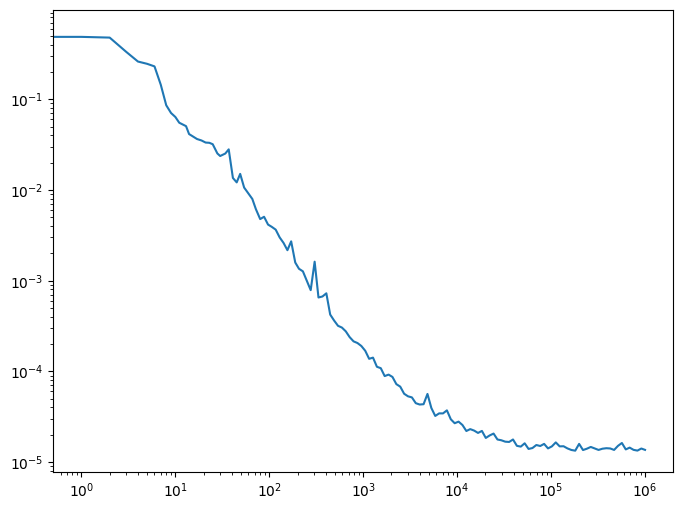

In [28]:
plt.figure(figsize=(8,6))
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(adamtimes,adamlosses,label='Adam, lr=0.0001')
colors = cm.summer(jnp.linspace(0, 0.75, len(adam_cos_decay_results)))
for (times, losses), color in zip(adam_cos_decay_results, colors):
    if jnp.array_equal(color, colors[0]):
        plt.loglog(times, losses, color=color, label='Adam cos decay')
    else:
        plt.loglog(times, losses, color=color)

plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)
plt.savefig('adam_cos_decay.pdf')

Panel of experiments for comparing DANA vs ADAM across beta.

In [41]:
ALPHA = 1.0
BETALIST = [0.3, 0.7, 1.0,1.3]
V = 8000
D = 4000
SGDBATCH=1
STEPS = 10**5

In [42]:
# Part 1: Generate data for each beta value
results_by_beta = []
for beta in BETALIST:
    key, newkey = random.split(key)
    # Create problem instance for this beta
    problem = PowerLawRF.initialize_random(ALPHA, beta, V, D, key=newkey)
    
    # Run DANA decay
    key, newkey = random.split(key)
    danadecaytimes, danadecaylosses = lsq_streaming_optax_simple(
        newkey,
        problem.get_data,
        SGDBATCH,
        STEPS,
        danadecayopt,
        jnp.zeros((problem.d,1)),
        problem.get_population_risk
        )
    
    # Run SGD with fixed learning rate
    key, newkey = random.split(key)
    optimizer = optax.sgd(learning_rate=0.8/problem.population_trace)
    sgdtimes, sgdlosses = lsq_streaming_optax_simple(
        newkey,
        problem.get_data,
        SGDBATCH,
        STEPS,
        optimizer,
        jnp.zeros((problem.d,1)),
        problem.get_population_risk
    )
    
    # Run Adam with cosine decay for different step sizes
    adam_cos_decay_results = []
    step_lengths = []
    current_steps = 1000
    while current_steps <= STEPS:
        step_lengths.append(current_steps)
        current_steps *= 4

    for steps in step_lengths:
        cos_decay = optax.cosine_decay_schedule(init_value=0.01, decay_steps=steps)
        adam_cos_decay = optax.adam(learning_rate=cos_decay)
        key, newkey = random.split(key)
        times, losses = lsq_streaming_optax_simple(
            newkey,
            problem.get_data,
            SGDBATCH,
            STEPS,
            adam_cos_decay,
            jnp.zeros((problem.d,1)),
            problem.get_population_risk
        )
        adam_cos_decay_results.append((times, losses))
    
    results_by_beta.append({
        'beta': beta,
        'dana': (danadecaytimes, danadecaylosses),
        'sgd': (sgdtimes, sgdlosses),
        'adam_cos': adam_cos_decay_results
    })



100%|██████████| 106/106 [00:39<00:00,  2.65it/s]


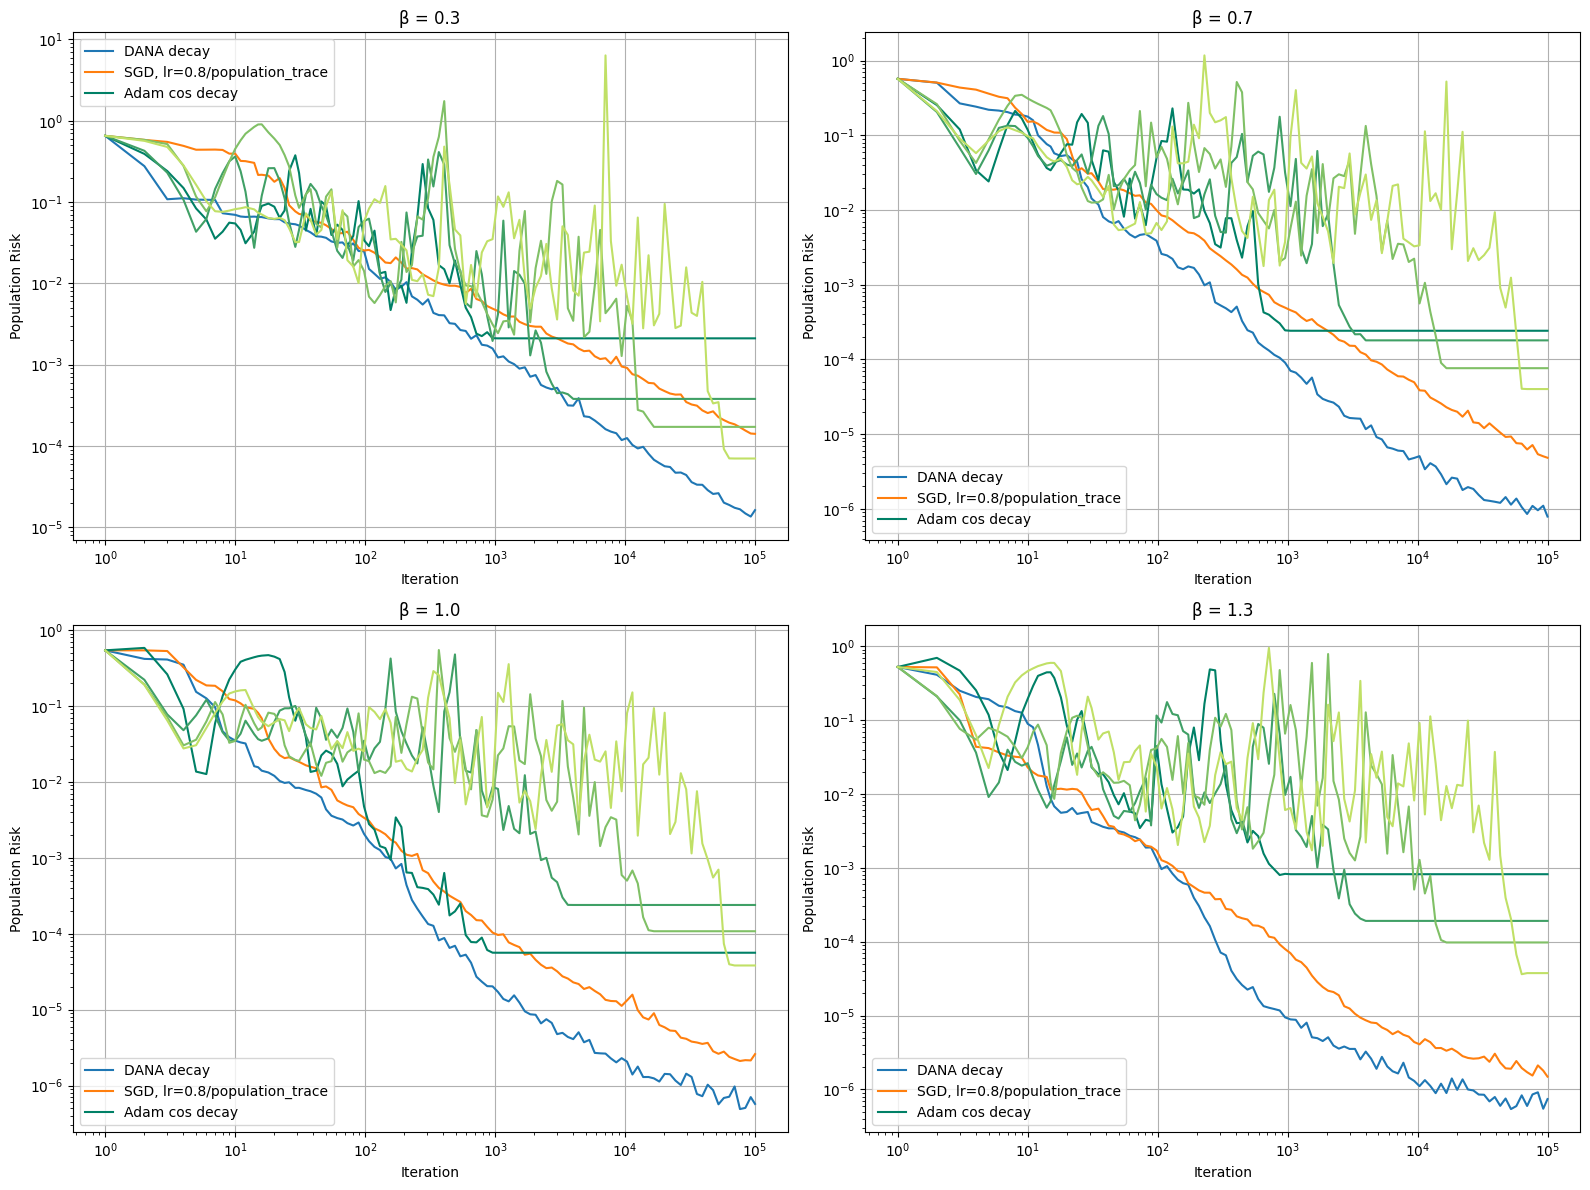

In [44]:
# Part 2: Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, result in enumerate(results_by_beta):
    beta = result['beta']
    danadecaytimes, danadecaylosses = result['dana']
    sgdtimes, sgdlosses = result['sgd']
    adam_cos_decay_results = result['adam_cos']
    
    # Plot on the corresponding subplot
    axes[idx].loglog(danadecaytimes+1, danadecaylosses, label='DANA decay')
    axes[idx].loglog(sgdtimes+1, sgdlosses, label='SGD, lr=0.8/population_trace')
    
    colors = cm.summer(jnp.linspace(0, 0.75, len(adam_cos_decay_results)))
    for (times, losses), color in zip(adam_cos_decay_results, colors):
        if jnp.array_equal(color, colors[0]):
            axes[idx].loglog(times+1, losses, color=color, label='Adam cos decay')
        else:
            axes[idx].loglog(times+1, losses, color=color)
    
    axes[idx].set_xlabel('Iteration')
    axes[idx].set_ylabel('Population Risk')
    axes[idx].set_title(f'β = {beta}')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('adam_cos_decay_beta_panel.pdf')


In [45]:
# Initialize lists to store ODE results for each beta
ode_results_by_beta = []

for beta in BETALIST:
    # Initialize the rhos for this beta
    initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
    initY = jnp.zeros(problem.d, dtype=jnp.float32)
    
    # Get theory rhos for this beta
    fake_eigs, rho_init = theory.theory_rhos(problem.alpha, beta, problem.d)
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)
    
    riskInftyTheory = theory.theory_limit_loss(problem.alpha, beta, problem.v, problem.d)
    
    Dt = 10**(-2)
    
    # Run ODE for this beta
    odeTimes, odeRisks = ode_resolvent_log_implicit(
        ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
        DanaHparams(g1, g2, g3, Delta),
        SGDBATCH, problem.d, STEPS, Dt)
        
    ode_results_by_beta.append({
        'beta': beta,
        'times': odeTimes,
        'risks': odeRisks
    })

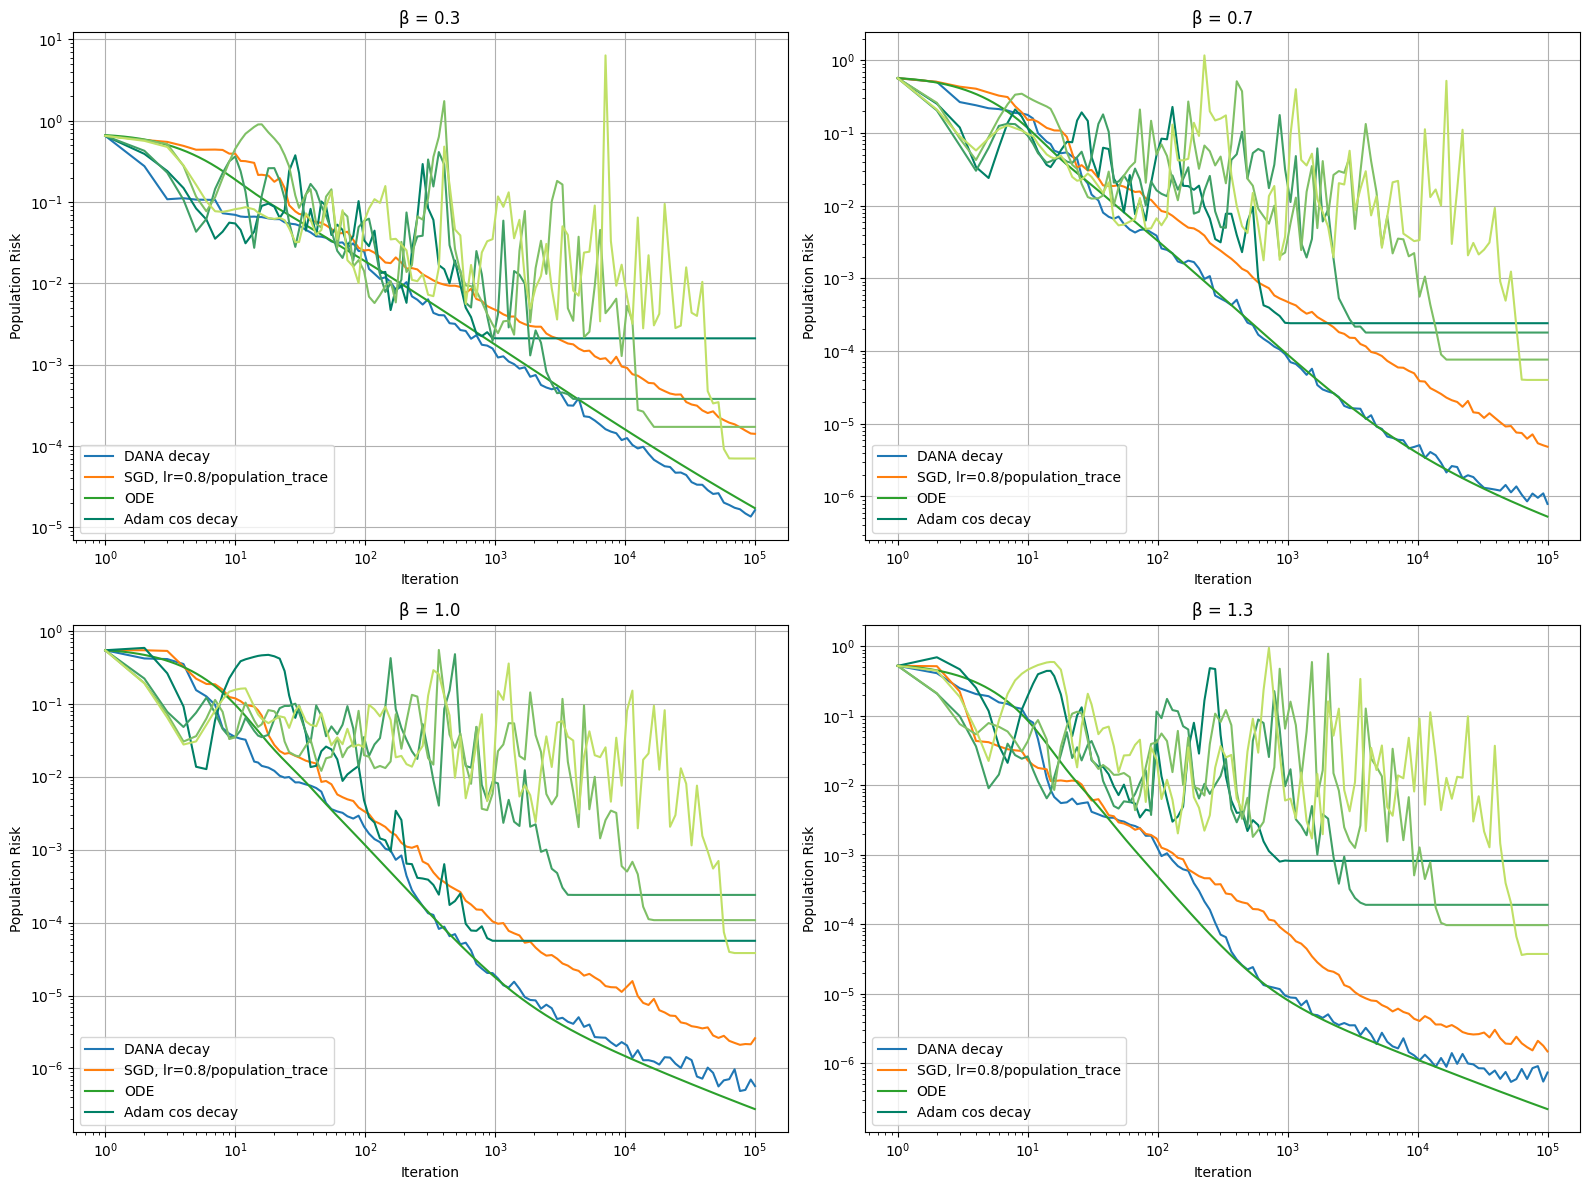

In [46]:
# Part 2: Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (result, ode_result) in enumerate(zip(results_by_beta, ode_results_by_beta)):
    beta = result['beta']
    danadecaytimes, danadecaylosses = result['dana']
    sgdtimes, sgdlosses = result['sgd']
    adam_cos_decay_results = result['adam_cos']
    
    # Plot on the corresponding subplot
    axes[idx].loglog(danadecaytimes+1, danadecaylosses, label='DANA decay')
    axes[idx].loglog(sgdtimes+1, sgdlosses, label='SGD, lr=0.8/population_trace')
    axes[idx].loglog(ode_result['times'], ode_result['risks'], label='ODE')
    
    colors = cm.summer(jnp.linspace(0, 0.75, len(adam_cos_decay_results)))
    for (times, losses), color in zip(adam_cos_decay_results, colors):
        if jnp.array_equal(color, colors[0]):
            axes[idx].loglog(times+1, losses, color=color, label='Adam cos decay')
        else:
            axes[idx].loglog(times+1, losses, color=color)
    
    axes[idx].set_xlabel('Iteration')
    axes[idx].set_ylabel('Population Risk')
    axes[idx].set_title(f'β = {beta}')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('adam_cos_decay_beta_panel.pdf')

In [33]:
# Part 1: Generate data for each beta value
dana_results_by_beta = []
for beta in BETALIST:
    key, newkey = random.split(key)
    # Create problem instance for this beta
    problem = PowerLawRF.initialize_random(ALPHA, beta, V, D, key=newkey)
    
    # Run DANA decay
    key, newkey = random.split(key)
    danadecaytimes, danadecaylosses = lsq_streaming_optax_simple(
        newkey,
        problem.get_data,
        SGDBATCH,
        STEPS,
        danadecayopt,
        jnp.zeros((problem.d,1)),
        problem.get_population_risk
        )
    
    # Initialize the rhos for this beta
    initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
    initY = jnp.zeros(problem.d, dtype=jnp.float32)
    
    # Get theory rhos for this beta
    fake_eigs, rho_init = theory.theory_rhos(problem.alpha, beta, problem.d)
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)
    
    riskInftyTheory = theory.theory_limit_loss(problem.alpha, beta, problem.v, problem.d)

    print("Risk infty theory: ", riskInftyTheory)
    
    Dt = 10**(-2)
    
    # Run ODE for this beta
    odeTimes, odeRisks = ode_resolvent_log_implicit(
        ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
        DanaHparams(g1, g2, g3, Delta),
        SGDBATCH, problem.d, STEPS, Dt)
    
    
    dana_results_by_beta.append({
        'beta': beta,
        'dana': (danadecaytimes, danadecaylosses),
        'ode': (odeTimes, odeRisks),
    })


  0%|          | 0/130 [00:00<?, ?it/s]

100%|██████████| 130/130 [00:33<00:00,  3.87it/s]


Risk infty theory:  0.00020000458


100%|██████████| 130/130 [00:32<00:00,  4.02it/s]


Risk infty theory:  2.2151919e-05


100%|██████████| 130/130 [00:32<00:00,  4.00it/s]


Risk infty theory:  1.2747676e-05


100%|██████████| 130/130 [00:33<00:00,  3.87it/s]


Risk infty theory:  1.0142438e-05


In [ ]:
theory.theory_limit_loss(problem.alpha, beta, problem.v, problem.d)


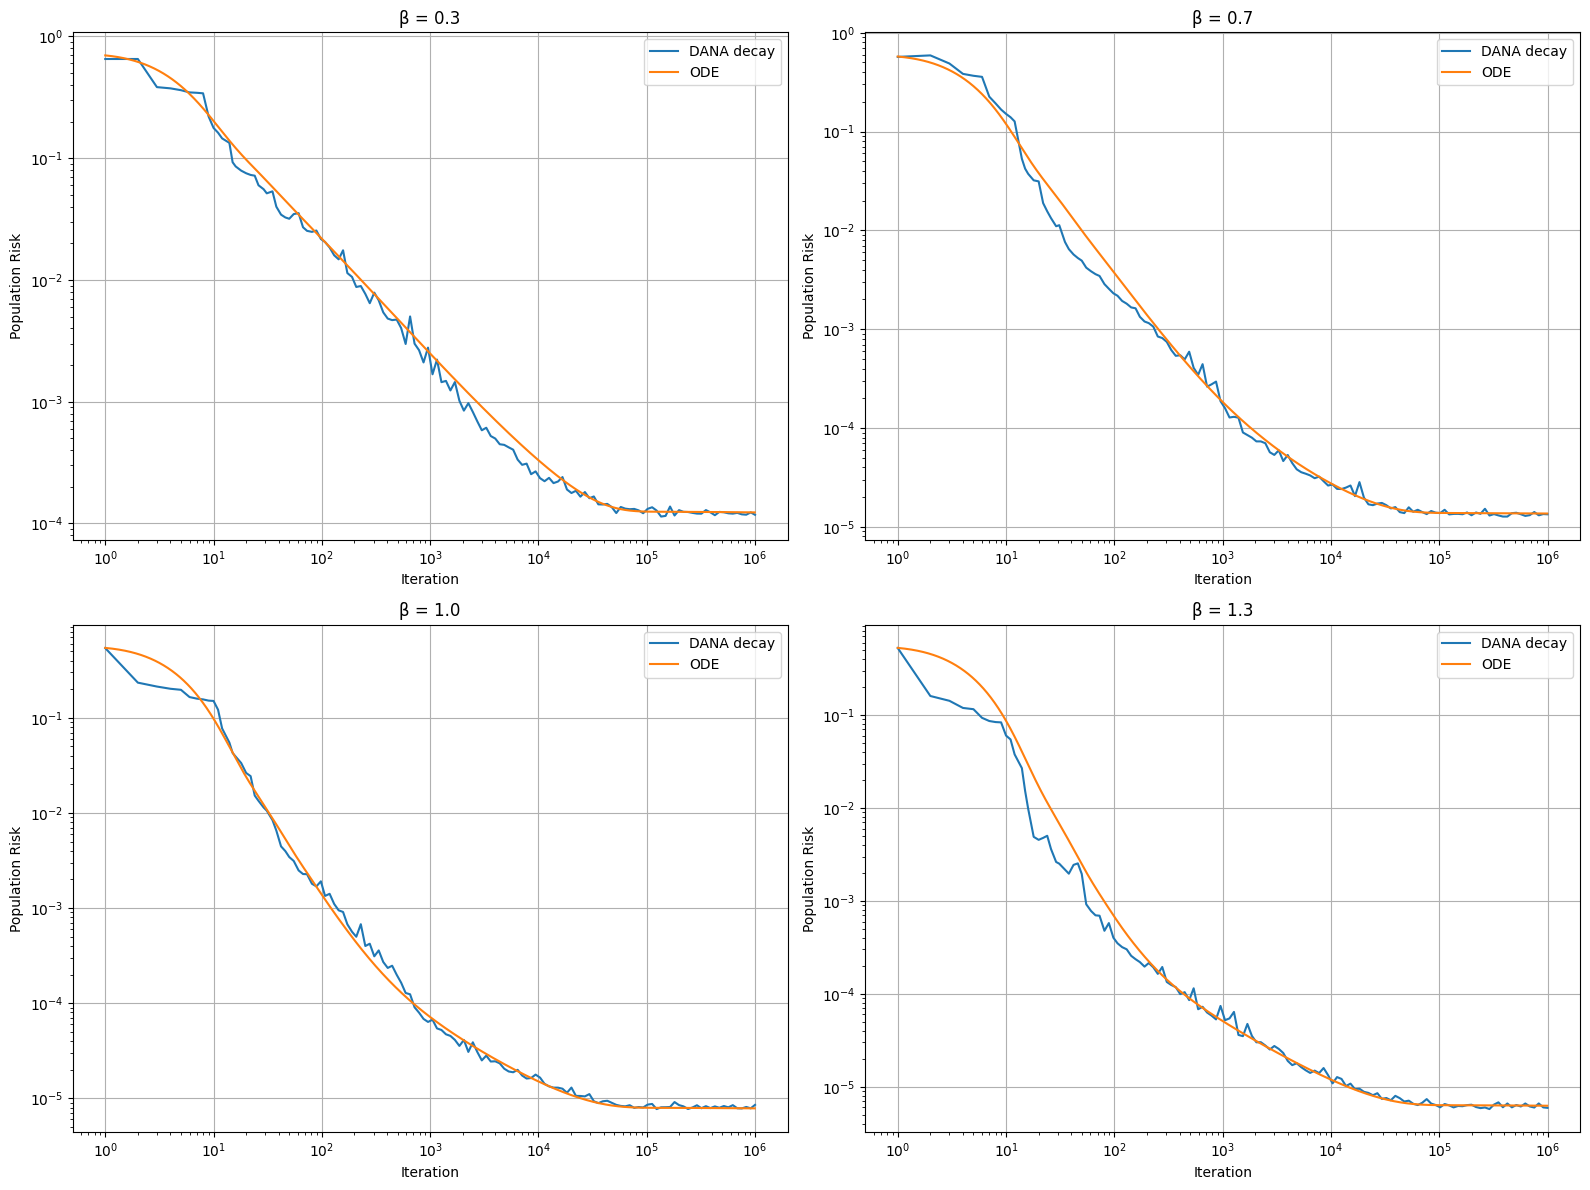

In [35]:
# Part 2: Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, result in enumerate(dana_results_by_beta):
    beta = result['beta']
    danadecaytimes, danadecaylosses = result['dana']
    odeTimes, odeRisks = result['ode']
    
    # Plot on the corresponding subplot
    axes[idx].loglog(danadecaytimes+1, danadecaylosses, label='DANA decay')
    axes[idx].loglog(odeTimes, odeRisks, label='ODE')
    
    axes[idx].set_xlabel('Iteration')
    axes[idx].set_ylabel('Population Risk')
    axes[idx].set_title(f'β = {beta}')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('dana_ode_beta_panel.pdf')